In [1]:
# Libraries needed to run the code
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt


### Creation of Knowledge Base using the generated sequential rules

This part of the code is the same as in notbeook 03_minSup_minConf_and_best_rules

In [2]:
df = pd.read_csv('sequential_rules_final.csv')

In [3]:
df[['prerequisite', 'outcome']] = df['rule'].str.split(' => ', expand=True)
df['prerequisite'] = df['prerequisite'].str.replace(r'[<{>\]}]', '', regex=True)
df['outcome'] = df['outcome'].str.replace(r'[<{>\]}]', '', regex=True)
df['prerequisite'] = df['prerequisite'].apply(lambda x: x.split(','))
df = df[~df['outcome'].str.contains('pha')]

### Mapping codes and final editing of Knoledge Base

In [4]:
panels_mapping = pd.read_csv('mimic_loinc_panels.csv')
panels_mapping = panels_mapping[['ParentLoinc','ParentName']]
panels_mapping.columns = ['code', 'lab']

labs_mapping = pd.read_csv('mimic_to_loinc.csv', index_col = 0)
labs_mapping = labs_mapping[['loinc_code','loinc_name']]
labs_mapping.columns = ['code', 'lab']

labs_mapping = pd.concat([labs_mapping,panels_mapping])
labs_mapping['code'] = 'lab_'+labs_mapping['code']

labs_mapping = labs_mapping.drop_duplicates(subset = ['code'])

df = df.merge(labs_mapping, left_on='outcome', right_on='code', how='left')

df['lab'] = np.where(df['code'] == 'lab_CBC', 'Complete Blood Count', df['lab'])

In [5]:
system_data = df[['prerequisite','outcome','lift','lab']].reset_index(drop=True)
system_data = system_data.sort_values(by='lift', ascending=False)
system_data['code'] = system_data['lab'].fillna('predefined basket')

### Method to generate three best options in each step

In [6]:
def giveOptions(history,system_data):
    options = list()
    metrics = list()
    for i in range(len(system_data)):
        option = True
        prerequisite_list = system_data['prerequisite'].iloc[i]
        for req in prerequisite_list:
            if(req not in history):
                option = False
        if option == True:
            outcome = system_data['outcome'].iloc[i]
            if(outcome not in history):
                if(outcome not in options):
                    options.append(system_data['outcome'].iloc[i])
                    metrics.append(system_data['lift'].iloc[i])
                    system_data['lift'].iloc[i]
                if(len(options)>2):
                    break
    

    fig, ax = plt.subplots(figsize=(16, 8))
    gap = 1.25  
    rect_width = 2.5 
    for i, option in enumerate(options):
        left = i * (rect_width + gap)
        ax.add_patch(plt.Rectangle((left, 0), rect_width, 0.5, color='lightblue', zorder=0, alpha=0.5))
        # Text annotation for option number
        ax.text(left + 0.1, 0.45, f"{i+1}", ha='left', va='center', color='black', fontsize=15)

        # Text annotation for option name
        ax.text(left + rect_width / 2, 0.25, option, ha='center', va='center', color='black', fontsize=13)
        
        option_explanation = system_data.loc[system_data['outcome'] == option, 'lab'].iloc[0]

        # Text annotation for option explanation
        ax.text(left + rect_width / 2, 0.2, option_explanation, ha='center', va='center', color='black', fontsize=9)
        
        # Text annotation for metric value
        ax.text(left + rect_width - 0.1, 0.45, "Lift is "+ f"{round(metrics[i], 3)}", ha='right', va='center', color='black', fontsize=15)
        
    ax.set_xlabel('Options')
    ax.set_title('Available Options')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Turn off axis
    plt.show()


    return options, metrics

### Recursive method to repeat the process iteratively till the end

In [7]:
def recursive_selection(history, options_lists,metrics_history,system_data,more_test_lists):
    options, metrics = giveOptions(history,system_data)
    options_lists.append(options)
    if not options:
        print("No available options.")
        return
    print("Available options:")
    for i, option in enumerate(options):
        print(f"{i+1}. {option} (lift: {round(metrics[i],3)})")
    
    print("Enter 0 to exit the method.")
    choice = input("Choose an option (enter the corresponding number): ")
    
    if choice == "0":
        print("Exiting the method.")
        return
    
    
    try:
        choice = int(choice)
        if choice < 1 or choice > len(options):
            print("Invalid choice. Please enter a valid number.")
            recursive_selection(history,options_lists,metrics_lists,system_data,more_test_lists)
            return
        
        chosen_option = options[choice - 1]
        history.append(chosen_option)
        print(f"You chose: {chosen_option}")
        chosen_metric = metrics[choice - 1]
        metrics_history.append(chosen_metric)
        

        
        more_tests = input("If you have more tests to include, type the names with commas. If not, just type x: ")
        

        
        
        more_tests = [test.strip() for test in more_tests.split(',')]
        
        more_test_lists.append(more_tests)
    
        
        for test in more_tests:
            history.append(test)

        
        recursive_selection(history,options_lists,metrics_history,system_data,more_test_lists)
    except ValueError:
        print("Invalid input. Please enter a valid number.")
        
        
        recursive_selection(history,options_lists,metrics_lists ,system_data,more_test_lists)

### Method to generate user journey diagram

In [8]:
def plot_options(prehistory,option_lists,metric_lists, selected_options,more_test_lists):
    fig, ax = plt.subplots(figsize=(32, 24))
    # Plot light blue rectangles for all options
    for i, options in enumerate(option_lists):
        for j, option in enumerate(options):
            rect = plt.Rectangle((j * 2, -i * 2), 1.5, 1, color='lightblue')
            ax.add_patch(rect)
            ax.text(j * 2 + 0.75, -i * 2 + 0.5, option, ha='center', va='center', fontsize = 24,fontweight='bold')
    
    ax.text(-0.5, 1.2, "Starting history of the subject is: "+str(prehist), ha='center', va='center', fontsize = 20)
    # Plot light green rectangles for selected options
    for i, option in enumerate(selected_options):
        if option in option_lists[i]:
            index = option_lists[i].index(option)
            rect = plt.Rectangle((index * 2, -i * 2), 1.5, 1, color='lightgreen')
            ax.add_patch(rect)
            if i > 0 and selected_options[i - 1] in option_lists[i - 1]:
                prev_index = option_lists[i - 1].index(selected_options[i - 1])
                x_start = (prev_index * 2 + 0.75)
                y_start = (- (i - 1) * 2 + 0.5) - 0.5 
                x_end = (index * 2 + 0.75) - 0.5 
                y_end = (-i * 2 + 0.5) + 0.5 
                ax.annotate("", xy=(x_end, y_end), xytext=(x_start, y_start), arrowprops=dict(arrowstyle="->", color='black',linewidth=2 * metric_lists[i]))
                ax.text(x_end, y_end+0.25, str(round(metric_lists[i],3)), ha='center', va='center', fontsize = 20)
                
                ax.text(-1.25, y_end + 0.65, 'Additional orders: ' + str((more_test_lists[i])), ha='center', va='center', fontsize=20)
                
                for i in range(len(selected_options)):
                    if(i == 0):
                        ax.text(-0.5, -i*2+ 0.5, str([i+1]), ha='center', va='center', fontsize=25)
                    else:
                        ax.text(-0.5, -i*2 + 0.4/i, str([i+1]), ha='center', va='center', fontsize=25)

                            
                            
    
    
    ax.set_xlim(-1, len(option_lists[0]) * 2)
    ax.set_ylim(-len(option_lists) * 2 + 1, 1)
    ax.set_aspect('equal')
    ax.set_axis_off()
    
    
    # Comment out if you want to save the plot
    #plt.savefig('example.pdf')
    plt.show()
    

### Preparing input parameters and running an example

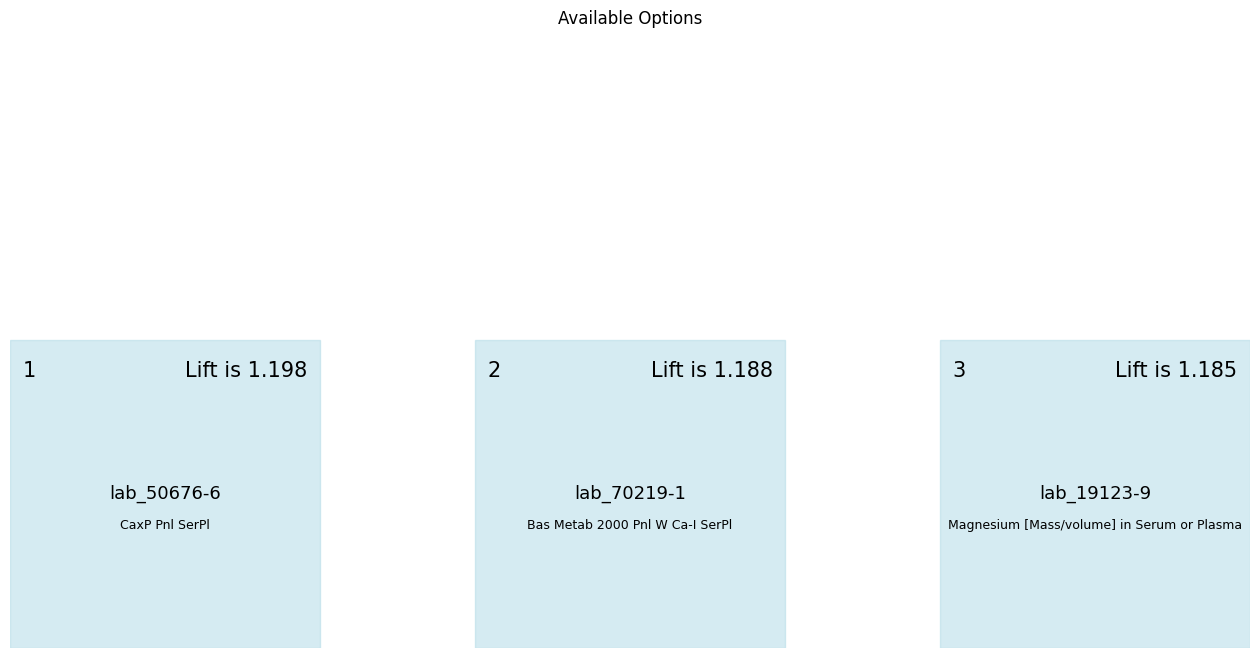

Available options:
1. lab_50676-6 (lift: 1.198)
2. lab_70219-1 (lift: 1.188)
3. lab_19123-9 (lift: 1.185)
Enter 0 to exit the method.
Choose an option (enter the corresponding number): 1
You chose: lab_50676-6
If you have more tests to include, type the names with commas. If not, just type x: x


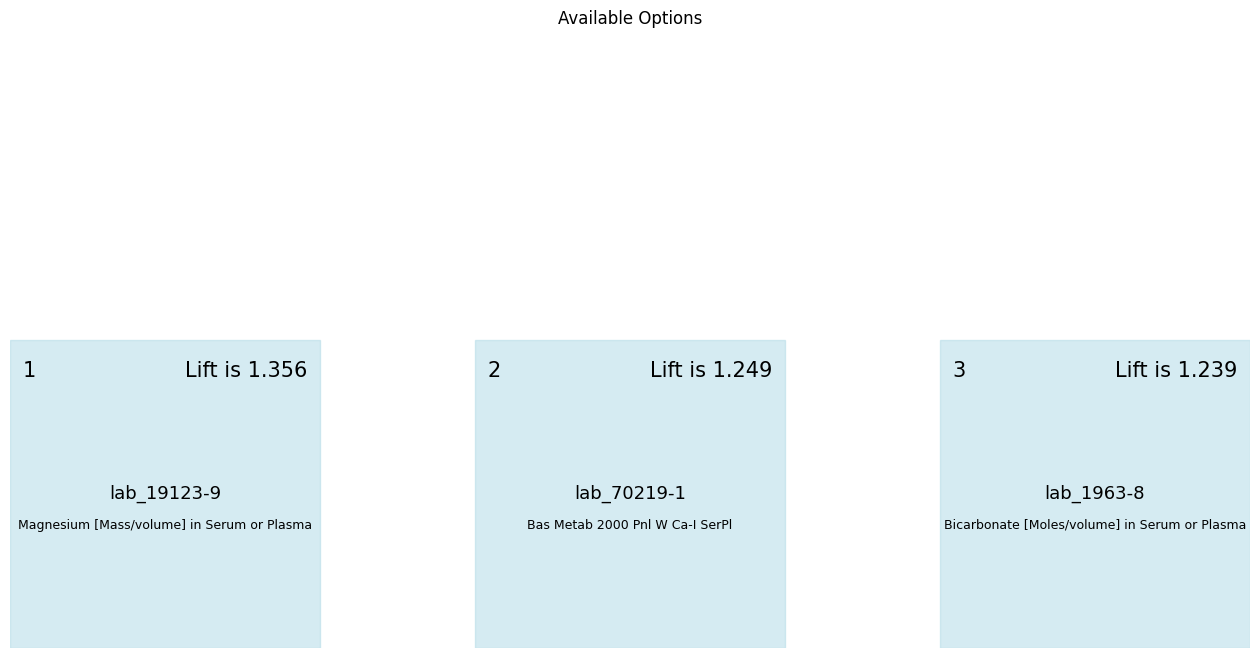

Available options:
1. lab_19123-9 (lift: 1.356)
2. lab_70219-1 (lift: 1.249)
3. lab_1963-8 (lift: 1.239)
Enter 0 to exit the method.
Choose an option (enter the corresponding number): 1
You chose: lab_19123-9
If you have more tests to include, type the names with commas. If not, just type x: basket_00014', lab_72680-2


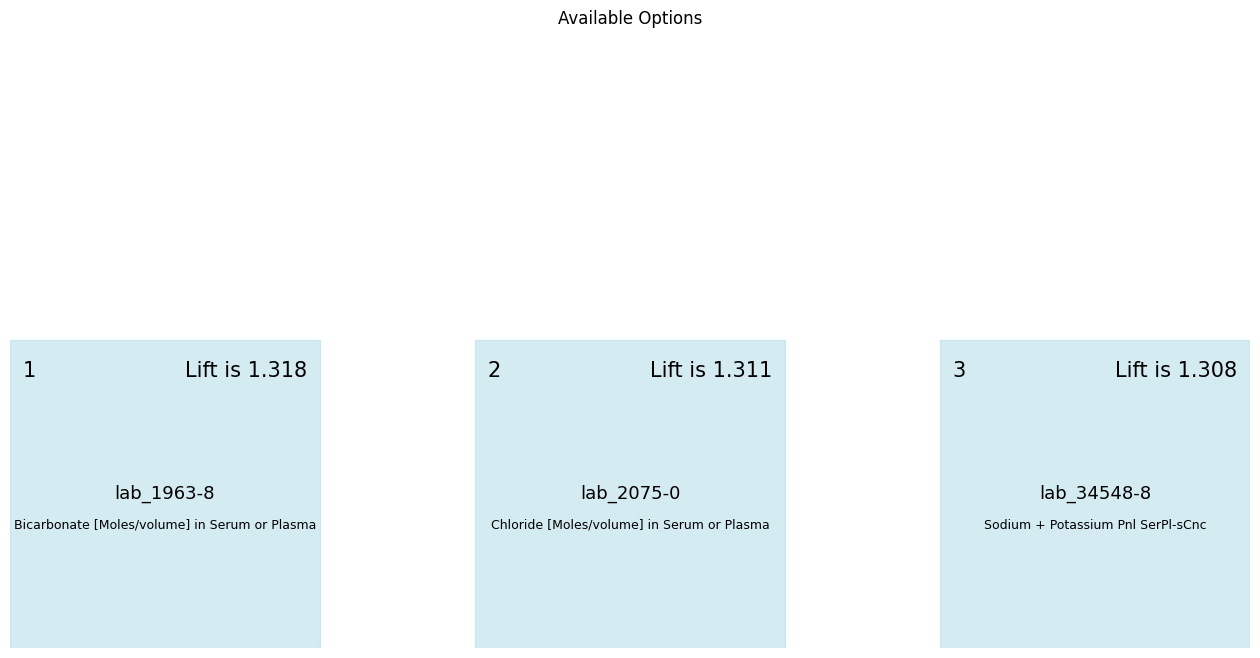

Available options:
1. lab_1963-8 (lift: 1.318)
2. lab_2075-0 (lift: 1.311)
3. lab_34548-8 (lift: 1.308)
Enter 0 to exit the method.
Choose an option (enter the corresponding number): 2
You chose: lab_2075-0
If you have more tests to include, type the names with commas. If not, just type x: pha_00010, lab_66746_9


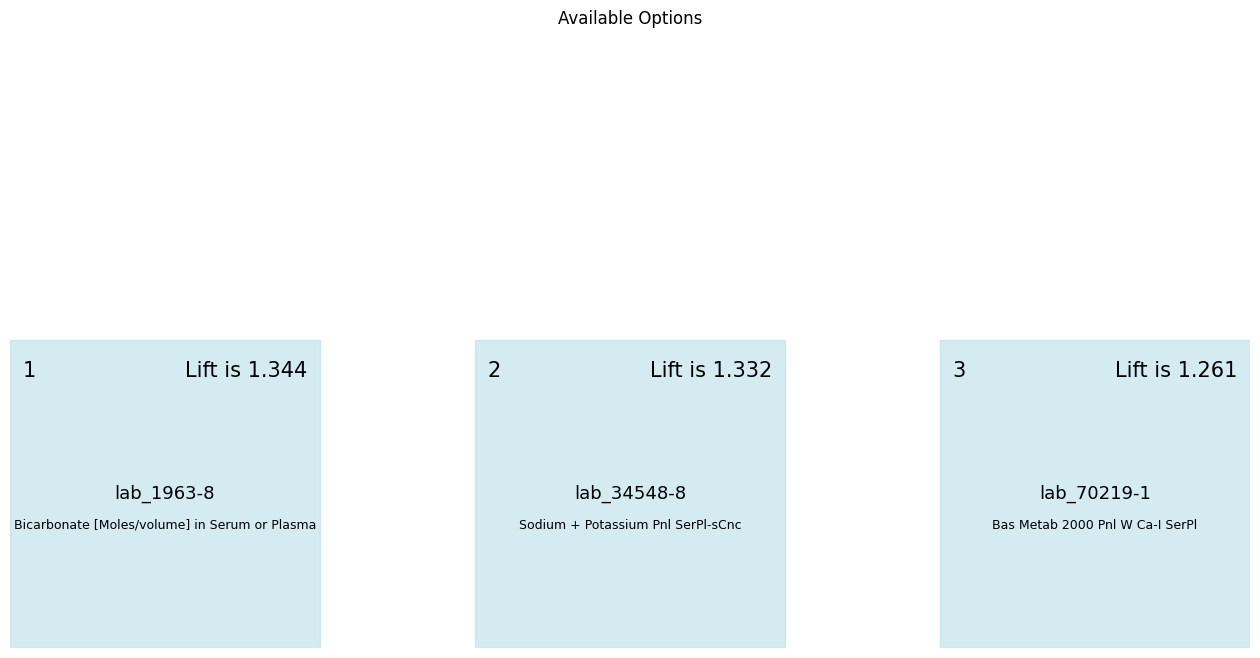

Available options:
1. lab_1963-8 (lift: 1.344)
2. lab_34548-8 (lift: 1.332)
3. lab_70219-1 (lift: 1.261)
Enter 0 to exit the method.
Choose an option (enter the corresponding number): 1
You chose: lab_1963-8
If you have more tests to include, type the names with commas. If not, just type x: x


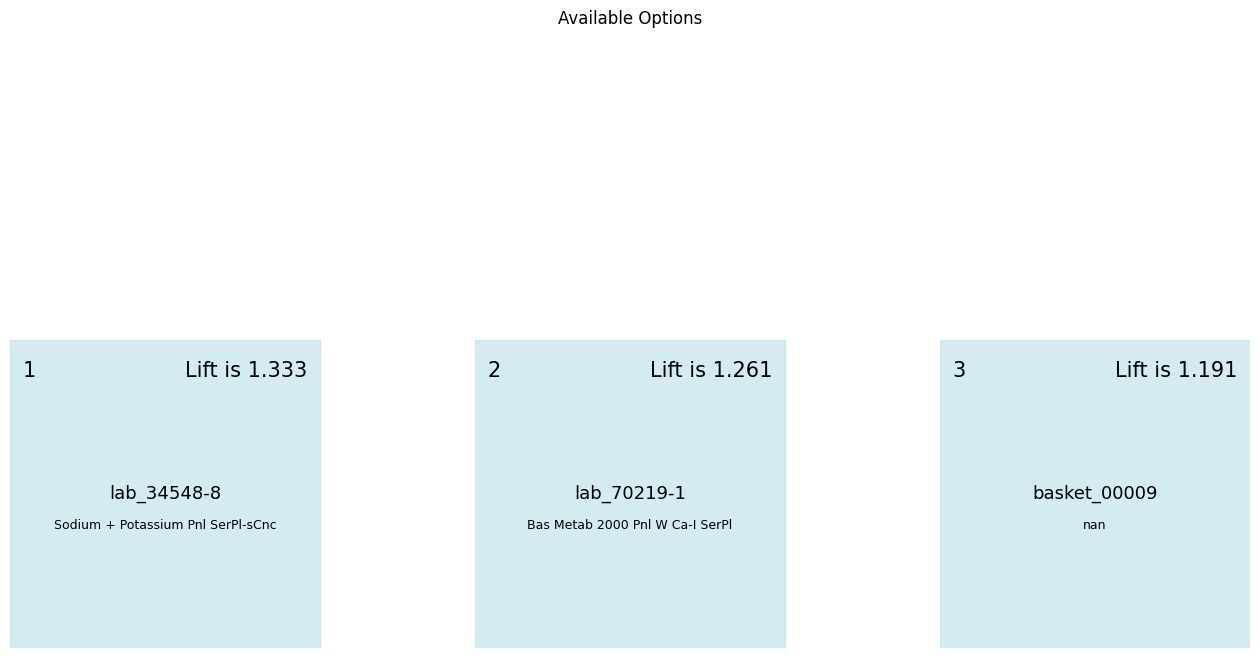

Available options:
1. lab_34548-8 (lift: 1.333)
2. lab_70219-1 (lift: 1.261)
3. basket_00009 (lift: 1.191)
Enter 0 to exit the method.
Choose an option (enter the corresponding number): 3
You chose: basket_00009
If you have more tests to include, type the names with commas. If not, just type x: x


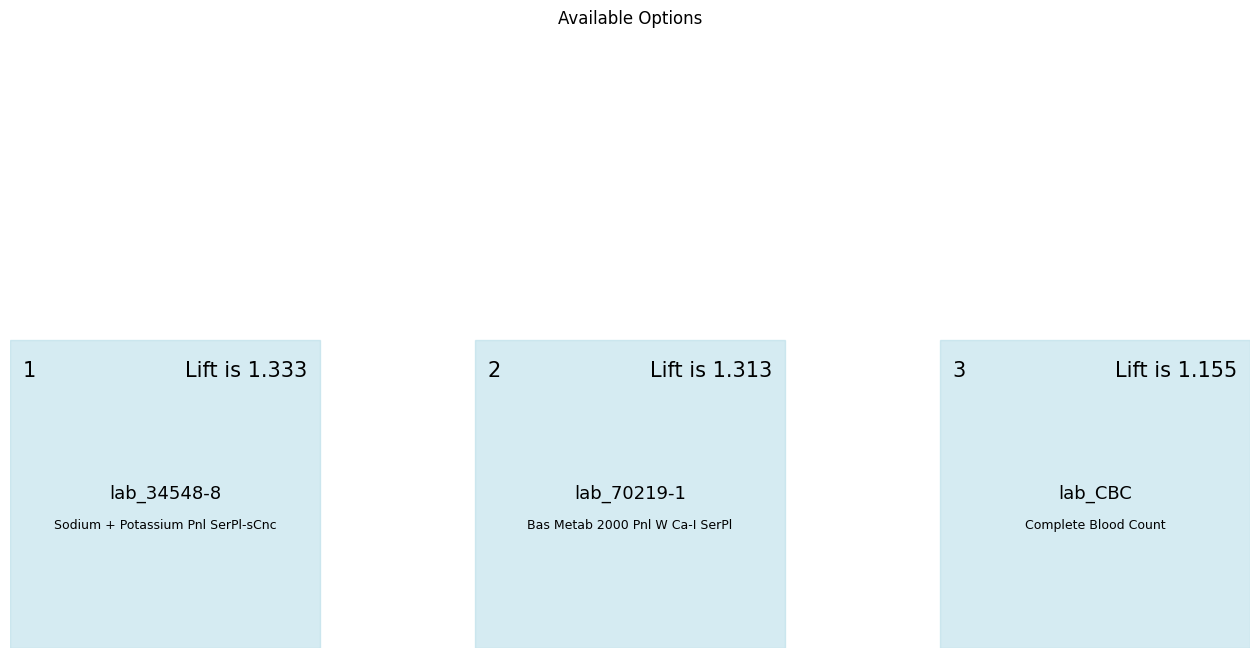

Available options:
1. lab_34548-8 (lift: 1.333)
2. lab_70219-1 (lift: 1.313)
3. lab_CBC (lift: 1.155)
Enter 0 to exit the method.
Choose an option (enter the corresponding number): 0
Exiting the method.


In [10]:
prehist = ['pha_00012','basket_00001','pha_00018']
prehist_len = len(prehist)
option_lists = []
metric_lists = []
more_test_lists = []
recursive_selection(prehist,option_lists,metric_lists,system_data,more_test_lists)

In [11]:
from itertools import chain


choices = prehist[prehist_len:]

flattened_more_test_lists = list(chain(*more_test_lists))
choices = [choice for choice in choices if choice not in flattened_more_test_lists]

prehist  = prehist[:prehist_len]
option_lists = option_lists[:len(choices)]

In [12]:
for idx, item in enumerate(more_test_lists):
    if item == ['x']:
        more_test_lists[idx] = ['No additional input']

### Generating corresponding user journey diagram

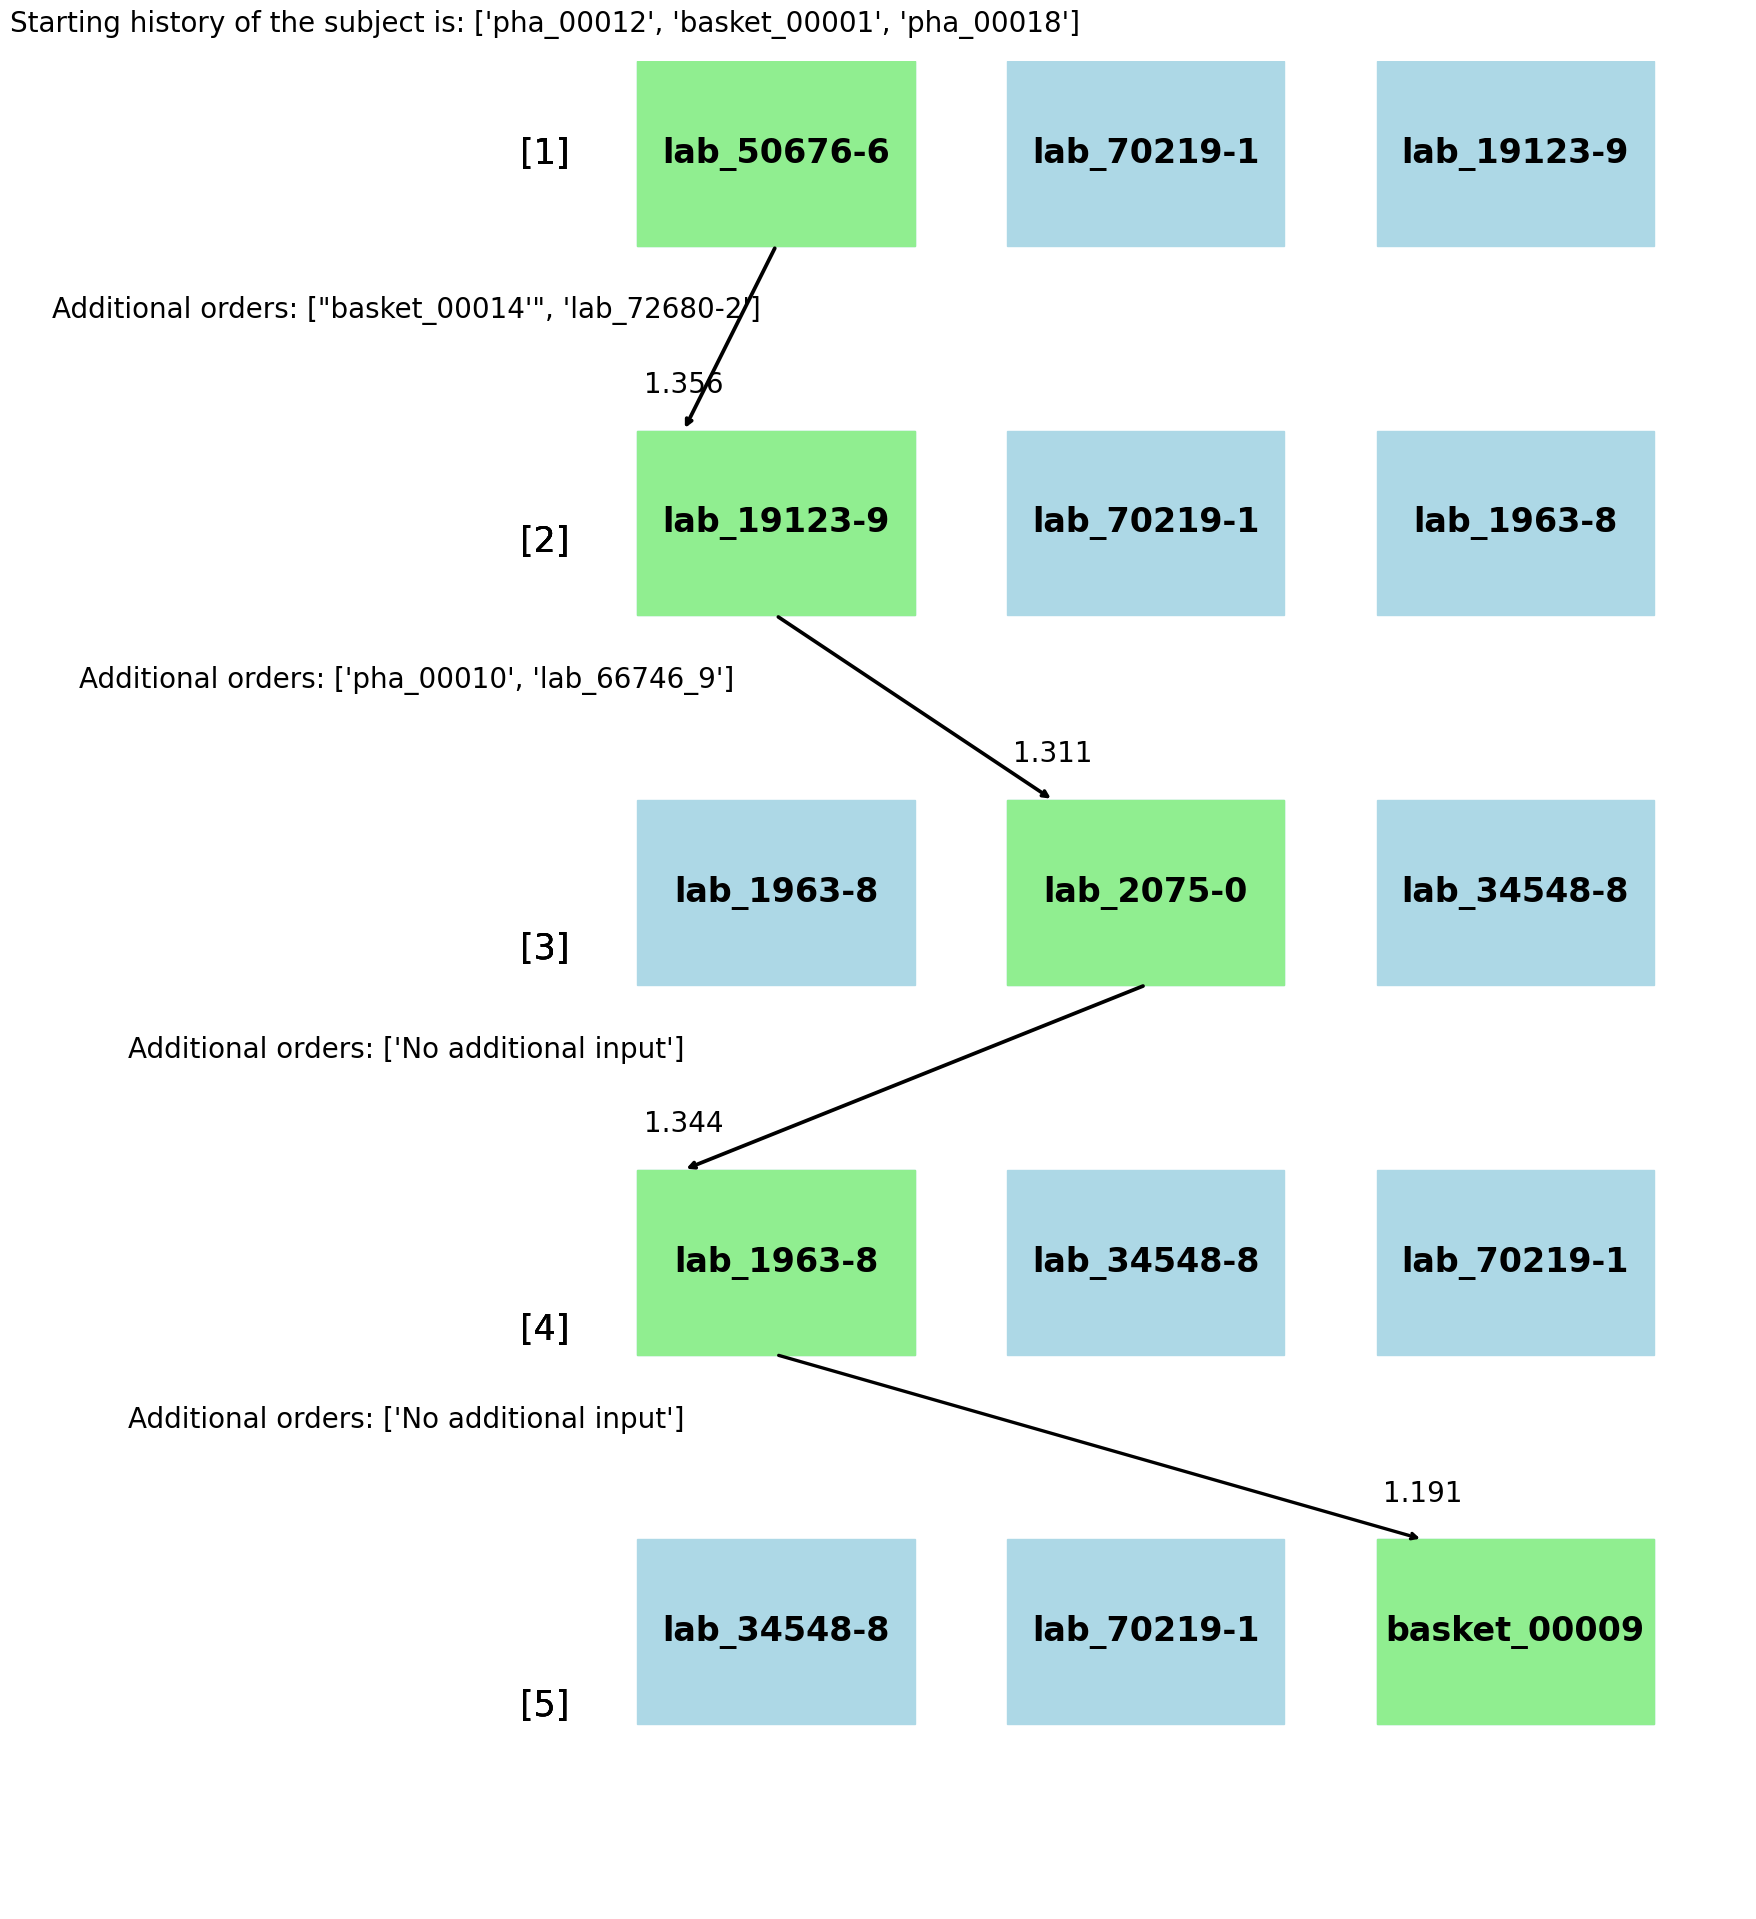

In [13]:
plot_options(prehist,option_lists,metric_lists,choices, more_test_lists)